In [3]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.datasets import make_circles
import pandas as pd

import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


# 1. Creating Toy dataset


This dataset will contain a dot and respective color in inner and outer circle. We have to predict with the coordinate if the dot is in outer or inner circle

In [4]:
X, y = make_circles(n_samples=1000, noise=0.04,random_state=42)

In [5]:
pandas_dataframe = pd.DataFrame({'X1': X[:, 0], 'X2': X[:, 1], 'labels': y})
pandas_dataframe.head(10)

,X1,X2,labels
0,0.748227,0.239083,1
1,-0.745096,0.160975,1
2,-0.822625,0.197621,1
3,-0.411433,0.682556,1
4,0.443905,-0.895829,0
5,-0.474766,0.692236,1
6,-0.014847,0.804486,1
7,0.765568,0.153643,1
8,-0.172507,-0.796646,1
9,-0.116051,1.031858,0


<Axes: xlabel='X1', ylabel='X2'>

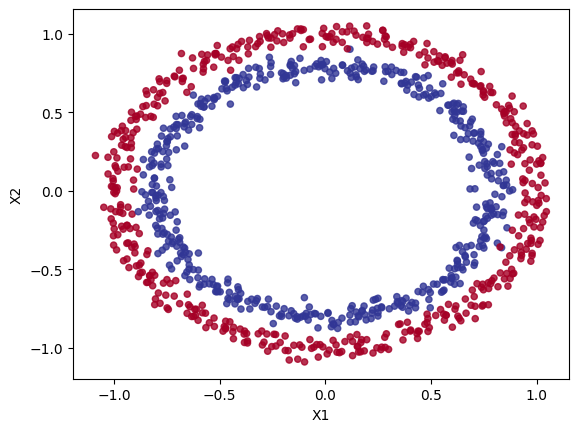

In [6]:
# Visualize with a plot
pandas_dataframe.plot(kind='scatter', x='X1', y='X2', c='labels', alpha= 0.8, colormap=plt.cm.RdYlBu, colorbar=False)

## Preprocessing

Converting our data into tenosrs so that we can apply torch methods

In [7]:
X = torch.from_numpy(pandas_dataframe[['X1','X2']].to_numpy())
y = torch.from_numpy(pandas_dataframe['labels'].to_numpy())
X = X.type(torch.float)
y = y.type(torch.float) 

creating train,test split

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

creating device agnostic code and constructing model

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
model_0 = nn.Sequential(
    nn.Linear(2, 5),
    nn.Linear(5, 1),
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

optimizer and loss functions

In [11]:
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.1)
loss_fn = nn.BCEWithLogitsLoss()

Accuracy Function

In [12]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

### 3. Training

In [13]:
def train(model, X_train, X_test, y_train, y_test, epochs= 1000):
    torch.manual_seed(42)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    loss_fn = nn.BCEWithLogitsLoss()

    for epoch in range (epochs):
        model.train()

        y_logits = model(X_train).squeeze()
        y_pred = torch.round(torch.sigmoid(y_logits))

        loss = loss_fn(y_logits, y_train)
        acc = accuracy_fn(y_train, y_pred)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        model.eval()
        with torch.inference_mode():
      # 1. Forward pass
            test_logits = model(X_test).squeeze()
            test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calculate loss and accuracy
            test_loss = loss_fn(test_logits, y_test)
            test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")
            print(y_logits.shape, y_train.shape)

In [14]:
train(model_0, X_train, X_test, y_train, y_test, epochs=100)

Epoch: 0 | Loss: 0.71716, Accuracy: 50.00% | Test Loss: 0.69498, Test Accuracy: 55.50%
torch.Size([800]) torch.Size([800])
Epoch: 10 | Loss: 0.69383, Accuracy: 47.88% | Test Loss: 0.69683, Test Accuracy: 39.00%
torch.Size([800]) torch.Size([800])
Epoch: 20 | Loss: 0.69365, Accuracy: 50.50% | Test Loss: 0.69652, Test Accuracy: 49.00%
torch.Size([800]) torch.Size([800])
Epoch: 30 | Loss: 0.69315, Accuracy: 46.50% | Test Loss: 0.69448, Test Accuracy: 46.50%
torch.Size([800]) torch.Size([800])
Epoch: 40 | Loss: 0.69304, Accuracy: 50.25% | Test Loss: 0.69521, Test Accuracy: 46.00%
torch.Size([800]) torch.Size([800])
Epoch: 50 | Loss: 0.69301, Accuracy: 50.38% | Test Loss: 0.69465, Test Accuracy: 48.00%
torch.Size([800]) torch.Size([800])
Epoch: 60 | Loss: 0.69298, Accuracy: 50.75% | Test Loss: 0.69464, Test Accuracy: 45.50%
torch.Size([800]) torch.Size([800])
Epoch: 70 | Loss: 0.69298, Accuracy: 51.38% | Test Loss: 0.69467, Test Accuracy: 46.00%
torch.Size([800]) torch.Size([800])
Epoch: 80

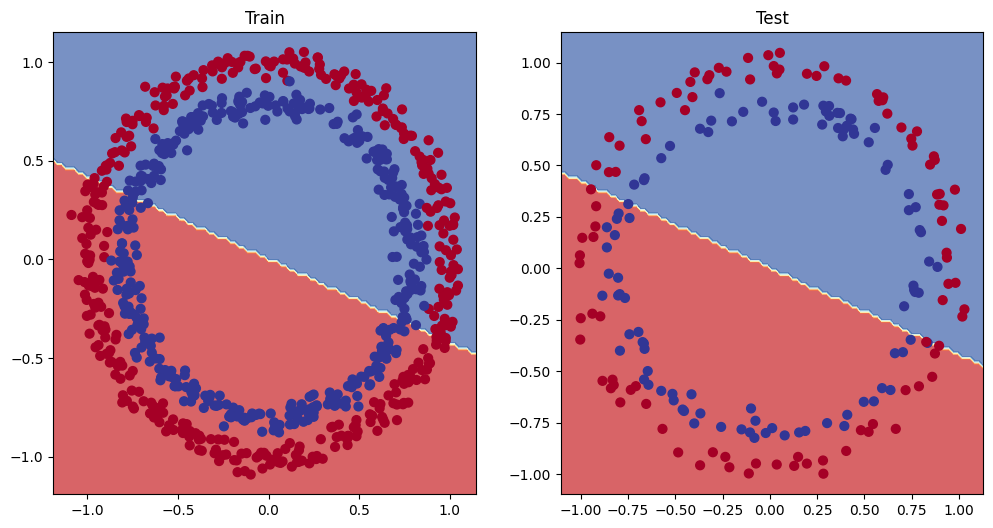

In [15]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

Using non linear activation for non linear data. Model2

In [16]:
# Build model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model 
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_1 = CircleModelV2().to(device)
print(model_1)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [17]:
train(model_1, X_train, X_test, y_train, y_test, epochs=100)

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69428, Test Accuracy: 50.00%
torch.Size([800]) torch.Size([800])
Epoch: 10 | Loss: 0.58669, Accuracy: 69.50% | Test Loss: 0.56786, Test Accuracy: 72.50%
torch.Size([800]) torch.Size([800])
Epoch: 20 | Loss: 0.22612, Accuracy: 97.12% | Test Loss: 0.25520, Test Accuracy: 94.50%
torch.Size([800]) torch.Size([800])
Epoch: 30 | Loss: 0.06261, Accuracy: 98.38% | Test Loss: 0.11313, Test Accuracy: 95.00%
torch.Size([800]) torch.Size([800])
Epoch: 40 | Loss: 0.03552, Accuracy: 98.50% | Test Loss: 0.09952, Test Accuracy: 97.00%
torch.Size([800]) torch.Size([800])
Epoch: 50 | Loss: 0.02351, Accuracy: 99.50% | Test Loss: 0.07936, Test Accuracy: 96.50%
torch.Size([800]) torch.Size([800])
Epoch: 60 | Loss: 0.01763, Accuracy: 99.75% | Test Loss: 0.08145, Test Accuracy: 96.50%
torch.Size([800]) torch.Size([800])
Epoch: 70 | Loss: 0.01367, Accuracy: 99.75% | Test Loss: 0.08798, Test Accuracy: 96.00%
torch.Size([800]) torch.Size([800])
Epoch: 80

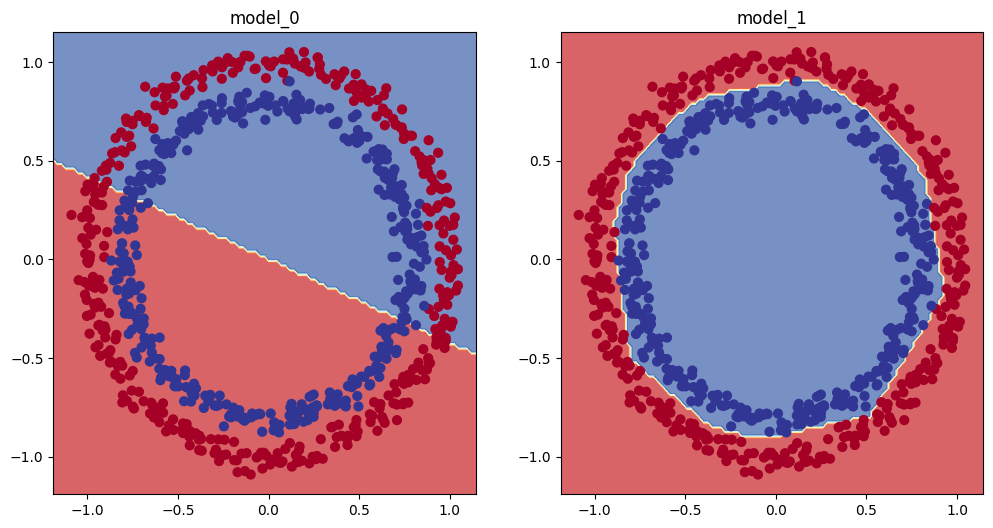

In [18]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("model_0")
plot_decision_boundary(model_0, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("model_1")
plot_decision_boundary(model_1, X_train, y_train) # model_3 = has non-linearity

In [19]:
model_2 = nn.Sequential(   
    nn.Linear(2, 10),
    nn.ReLU(),
    nn.Linear(10, 10),
    nn.ReLU(),
    nn.Linear(10, 1)
).to(device)

In [20]:
train(model_2, X_train, X_test, y_train, y_test, epochs=100)

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69428, Test Accuracy: 50.00%
torch.Size([800]) torch.Size([800])
Epoch: 10 | Loss: 0.58669, Accuracy: 69.50% | Test Loss: 0.56786, Test Accuracy: 72.50%
torch.Size([800]) torch.Size([800])
Epoch: 20 | Loss: 0.22612, Accuracy: 97.12% | Test Loss: 0.25520, Test Accuracy: 94.50%
torch.Size([800]) torch.Size([800])
Epoch: 30 | Loss: 0.06261, Accuracy: 98.38% | Test Loss: 0.11313, Test Accuracy: 95.00%
torch.Size([800]) torch.Size([800])
Epoch: 40 | Loss: 0.03552, Accuracy: 98.50% | Test Loss: 0.09952, Test Accuracy: 97.00%
torch.Size([800]) torch.Size([800])
Epoch: 50 | Loss: 0.02351, Accuracy: 99.50% | Test Loss: 0.07936, Test Accuracy: 96.50%
torch.Size([800]) torch.Size([800])
Epoch: 60 | Loss: 0.01763, Accuracy: 99.75% | Test Loss: 0.08145, Test Accuracy: 96.50%
torch.Size([800]) torch.Size([800])
Epoch: 70 | Loss: 0.01367, Accuracy: 99.75% | Test Loss: 0.08798, Test Accuracy: 96.00%
torch.Size([800]) torch.Size([800])
Epoch: 80

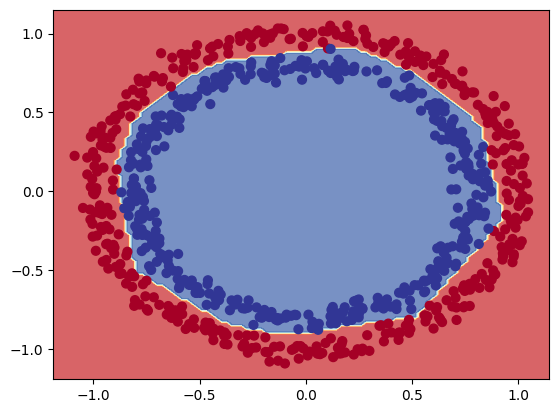

In [21]:
plot_decision_boundary(model_2, X_train, y_train) # model_3 = has non-linearity